# Compute metrics for different runs and plot them
##### author: Elizabeth A. Barnes, Randal J. Barnes and Mark DeMaria
##### version: v0.2.0

In [1]:
import datetime
import os
import pickle
import pprint
import time

import experiment_settings
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
from build_data import build_hurricane_data
import model_diagnostics
import prediction
import pandas as pd

import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

dpiFig = 400

mpl.rcParams["figure.facecolor"] = "white"
mpl.rcParams["figure.dpi"] = 150
np.warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning)

In [2]:
__author__ = "Randal J Barnes and Elizabeth A. Barnes"
__version__ = "03 June 2022"

EXP_NAME_LIST = (
                 "intensity201_AL24",
                 "intensity202_AL48",    
                 "intensity203_AL72",
                 "intensity204_AL96",    
                 "intensity205_AL120",    
    
                 "intensity301_EPCP24",
                 "intensity302_EPCP48", 
                 "intensity303_EPCP72",
                 "intensity304_EPCP96",    
                 "intensity305_EPCP120",        
                 )

APPEND_NAME = ''#'_paper'

DATA_PATH = "data/"
MODEL_PATH = "saved_models/"
METRIC_PATH = "saved_metrics/"
FIGURE_PATH = "figures/paper_figures/"
PREDICTION_PATH = "saved_predictions/"

## Plotting functions

In [3]:
FS = 16

### for white background...
plt.rc('text',usetex=True)
plt.rc('font',**{'family':'sans-serif','sans-serif':['Avant Garde']}) 
plt.rc('savefig',facecolor='white')
plt.rc('axes',facecolor='white')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('axes',labelcolor='dimgrey')
plt.rc('xtick',color='dimgrey')
plt.rc('ytick',color='dimgrey')
################################  
################################  
def adjust_spines(ax, spines):
    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', 5))
        else:
            spine.set_color('none')  
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        ax.yaxis.set_ticks([])
    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        ax.xaxis.set_ticks([]) 

def format_spines(ax):
    adjust_spines(ax, ['left', 'bottom'])
    ax.spines['top'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.spines['left'].set_color('dimgrey')
    ax.spines['bottom'].set_color('dimgrey')
    ax.spines['left'].set_linewidth(2)
    ax.spines['bottom'].set_linewidth(2)
    ax.tick_params('both',length=4,width=2,which='major',color='dimgrey')
#     ax.yaxis.grid(zorder=1,color='dimgrey',alpha=0.35)    
    

## Get Sample Sizes for Paper

In [4]:
import tensorflow as tf

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)

    TESTING_YEARS = 2020
    settings["years_test"] = (TESTING_YEARS,)
    
    RNG_SEED = 416
    settings['rng_seed'] = RNG_SEED
    seed_dict = {}
    
    NETWORK_SEED_LIST = [settings["rng_seed"]]
    network_seed = NETWORK_SEED_LIST[0]
    tf.random.set_seed(network_seed)  # This sets the global random seed.  

    # get the data
    (
        data_summary,        
        x_train,
        onehot_train,
        x_val,
        onehot_val,
        x_test,
        onehot_test,        
        x_valtest,
        onehot_valtest,
        df_train,
        df_val,
        df_test,
        df_valtest,
    ) = build_hurricane_data(DATA_PATH, settings, verbose=0)
    
    print(exp_name + ' ' + str(np.shape(x_train)[0]) + ' ' + str(np.shape(x_val)[0]) + ' ' + str(np.shape(x_test)[0]))
 

intensity201_AL24 1647 200 456
intensity202_AL48 1234 200 354
intensity203_AL72 898 200 264
intensity204_AL96 659 200 185
intensity205_AL120 477 200 122
intensity301_EPCP24 2564 200 178
intensity302_EPCP48 1961 200 124
intensity303_EPCP72 1478 200 80
intensity304_EPCP96 1083 200 46
intensity305_EPCP120 760 200 26


## Get the dataframe

In [5]:
df_metrics = pd.DataFrame()

for exp_name in EXP_NAME_LIST:
    settings = experiment_settings.get_settings(exp_name)

    # set testing data
    if settings["test_condition"] == "leave-one-out":
        TESTING_YEARS_LIST = np.arange(2013,2022)
    elif settings["test_condition"] == "years":
        TESTING_YEARS_LIST = (np.copy(settings["years_test"]))
    else:
        raise NotImplementError('no such testing condition')
        
        
    for testing_years in TESTING_YEARS_LIST:        
        # set testing year
        settings["years_test"] = (testing_years,)
    
    
        for rng_seed in settings["rng_seed_list"]:
            settings['rng_seed'] = rng_seed
            NETWORK_SEED_LIST = [settings["rng_seed"]]
            network_seed = NETWORK_SEED_LIST[0]

            model_name = (
                exp_name + "_" + 
                str(testing_years) + '_' +
                settings["uncertainty_type"] + '_' + 
                f"network_seed_{network_seed}_rng_seed_{settings['rng_seed']}"
            )

            # load the metric filename
            metric_filename = METRIC_PATH + model_name + '_metrics.pickle'  
            if os.path.exists(metric_filename)==False:
                metric_filename = METRIC_PATH + model_name + '_metrics.pkl'  
                if os.path.exists(metric_filename)==False:
                    print(metric_filename + ' DOES NOT exist. Skipping...')
                    continue

            # pprint.pprint(model_name)
            df = pd.read_pickle(metric_filename)
            # print("***remove these***")
            # df['basin_lead'] = exp_name[exp_name.rfind('_')+1:]
            # df['testing_years'] = settings["years_test"]

            df_metrics = pd.concat([df_metrics,df])
# get best validation results            
idx = df_metrics.groupby(['exp_name', 'testing_years'], sort=False)['median_error_reduction_val'].transform(max) == df_metrics['median_error_reduction_val']
df_metrics_bestval = df_metrics[idx]

BEST_VAL_ONLY = True
if BEST_VAL_ONLY:
    print("**plotting only the best seed for validation error reductions**")
    APPEND_NAME = ''
    df_metrics = df_metrics[idx]
    df_bestval = df_metrics[["exp_name","basin_lead","testing_years","rng_seed","network_seed"]]
    df_bestval.to_pickle(PREDICTION_PATH + "best_shash3_validation_seeds.pickle")
else:
    APPEND_NAME = APPEND_NAME + "_allNetworks"

saved_metrics/intensity201_AL24_2017_shash3_network_seed_739_rng_seed_739_metrics.pkl DOES NOT exist. Skipping...
saved_metrics/intensity201_AL24_2018_shash3_network_seed_222_rng_seed_222_metrics.pkl DOES NOT exist. Skipping...
saved_metrics/intensity201_AL24_2018_shash3_network_seed_333_rng_seed_333_metrics.pkl DOES NOT exist. Skipping...
saved_metrics/intensity201_AL24_2018_shash3_network_seed_416_rng_seed_416_metrics.pkl DOES NOT exist. Skipping...
saved_metrics/intensity201_AL24_2018_shash3_network_seed_599_rng_seed_599_metrics.pkl DOES NOT exist. Skipping...
saved_metrics/intensity201_AL24_2018_shash3_network_seed_739_rng_seed_739_metrics.pkl DOES NOT exist. Skipping...
saved_metrics/intensity201_AL24_2019_shash3_network_seed_222_rng_seed_222_metrics.pkl DOES NOT exist. Skipping...
saved_metrics/intensity201_AL24_2019_shash3_network_seed_333_rng_seed_333_metrics.pkl DOES NOT exist. Skipping...
saved_metrics/intensity201_AL24_2019_shash3_network_seed_416_rng_seed_416_metrics.pkl DO

## Major summary for analysis

In [6]:
df_metrics[df_metrics["exp_name"]=="intensity302_EPCP48"]["iqr_error_spearman_valtest"]#["iqr_capture_valtest"]

0    0.394343
0    0.434932
0    0.371622
0    0.341260
0    0.375923
0    0.343018
0    0.400213
0    0.417872
0    0.344879
Name: iqr_error_spearman_valtest, dtype: float64

In [7]:
SHOW_SUMMARY = False
if SHOW_SUMMARY:
    colors = ('#284E60','#E1A730','#C3B1E1')

    x_axis_list = ("exp_name",)#("basin_lead",)#("basin_lead", "exp_name")

    metric_list = ('mean_error',
                  'mean_error_reduction',
                  'median_error',
                  'median_error_reduction',                                                                        
                  'iqr_error_spearman',
                  'mode_error_reduction',                                                                        
                  # 'iqr_error_pearson',                                  
                  # 'mode_error',
                  'pit_D',
                  'iqr_capture')
    metric_data = '_test'

    for x_axis in x_axis_list:
        f, axs = plt.subplots(4, 2, figsize=(15,20))
        axs = axs.flatten()

        for imetric, metric in enumerate([m + metric_data for m in metric_list]):
            ax = axs[imetric]
            g1 = sns.boxplot(x=x_axis, 
                             y=metric, 
                             hue="uncertainty_type",
                             data=df_metrics,
                             palette=colors,
                             boxprops={'alpha':.2,
                                       'edgecolor': 'white',
                                      },
                             fliersize=0,
                             ax=ax)
            g2 = sns.swarmplot(x=x_axis, 
                               y=metric, 
                               hue="uncertainty_type",
                               palette=colors,
                               data=df_metrics, 
                               dodge=True,
                               ax=ax)

            if(metric=='iqr_capture'):
                ax.axhline(y=0.5,linewidth=3,linestyle='--',color='gray')
                ax.set_ylim(0,1.0)
            if(metric=='pit_d'):
                ax.set_ylim(0,None)
            if(metric.find('reduction') > -1):
                ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')
                ax.set_ylim(-4.,4.)
            if(metric.find('reduction') == -1 and metric.find('n_error') > -1):
                ax.set_ylim(0.,22.)
            if(metric.find('iqr_error')> -1):
                ax.set_ylim(-.3,1.)
                ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')        


            ax.set_title(metric + APPEND_NAME)
            ax.legend(fontsize=10,frameon=True)
            ax.set_xticklabels(ax.get_xticklabels(),rotation = 30)

        plt.tight_layout()    
        # plt.savefig(FIGURE_PATH + 'comparisonsMetrics' + APPEND_NAME + '_' + x_axis + '.png', dpi=dpiFig)    
        # plt.close()
        plt.show()

## Figure for main paper

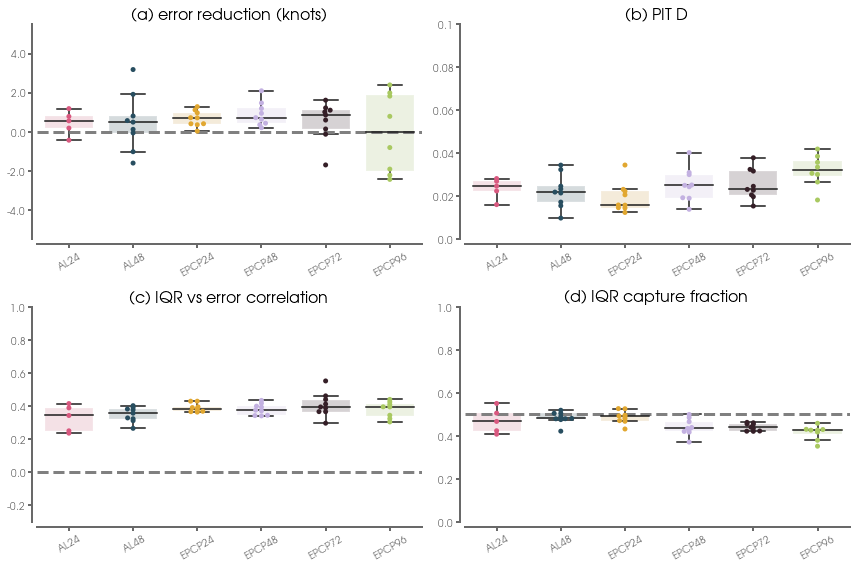

In [8]:
FS_A = 10
colors = ('#D95980','#284E60','#E1A730','#C3B1E1','#351F27','#A9C961')
panel_letters = ('(a)','(b)','(c)','(d)')
x_axis_list = ("basin_lead",)#("basin_lead", "exp_name")

metric_data = ''
metric_list = ('median_error_reduction_test',
               'pit_D_valtest',
               'iqr_error_spearman_valtest',                                                                     
               'iqr_capture_valtest',
              )
title_text = ('(a) error reduction (knots)',
              '(b) PIT D',
              '(c) IQR vs error correlation',
              '(d) IQR capture fraction',
             )

for x_axis in x_axis_list:
    f, axs = plt.subplots(2, 2, figsize=(15/1.25,10/1.25))
    axs = axs.flatten()
    
    for imetric, metric in enumerate([m + metric_data for m in metric_list]):
        ax = axs[imetric]
        g1 = sns.boxplot(x=x_axis, 
                         y=metric, 
                         hue="exp_name",
                         data=df_metrics,
                         palette=colors,
                         width=.75,
                         dodge=False,
                         boxprops={'alpha':.2,
                                   'edgecolor': 'white',
                                  },
                         fliersize=0,
                         ax=ax)
        g2 = sns.swarmplot(x=x_axis, 
                           y=metric, 
                           hue="exp_name",
                           palette=colors,
                           data=df_metrics, 
                           dodge=False,
                           size=5,
                           ax=ax)

        if(metric.find('iqr_capture') > -1):
            ax.axhline(y=0.5,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(0,1.0)
        if(metric.find('pit_D') > -1):
            ax.set_ylim(0,.1)
        if(metric.find('reduction') > -1):
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')
            ax.set_ylim(-5.5,5.5)
        if(metric.find('reduction') == -1 and metric.find('n_error') > -1):
            ax.set_ylim(0.,22.)
        if(metric.find('iqr_error')> -1):
            ax.set_ylim(-.3,1.)
            ax.axhline(y=0.0,linewidth=3,linestyle='--',color='gray')        

        ax.set_title(title_text[imetric],
                     fontsize=FS,
                     color='k',
                    )
            
#         ax.set_title(panel_letters[imetric] + ' ' + metric + APPEND_NAME,
#                      fontsize=FS,
#                      color='k',
#                     )
        # ax.legend(fontsize=10,frameon=True)
        ax.get_legend().remove()
        x_tick_labels = ax.get_xticklabels()
        ax.set_xticklabels(x_tick_labels,rotation = 30)
        yticks = np.around(ax.get_yticks(),3)
        ax.set_yticklabels(yticks)       
        ax.set_ylabel('')
        
        format_spines(ax)
        ax.set_xticklabels(x_tick_labels,rotation = 30)
        ax.set_xlabel('')
        
    plt.tight_layout()    
    plt.savefig(FIGURE_PATH + 'comparisonsMetrics' + APPEND_NAME + '.png', dpi=dpiFig)    
    # plt.close()
    plt.show()

In [9]:
# error('STOPPING FOR SHASH-TFP TESTING')

In [10]:
# df_metrics[df_metrics["exp_name"]=="intensity302_EPCP48"][["testing_years","median_error_reduction_val","median_error_reduction_test", "rng_seed"]]
for exp_name in df_metrics["exp_name"].unique():
    df_show = df_metrics.loc[df_metrics["exp_name"]==exp_name][["exp_name",
                                                                "testing_years",                                                                
                                                                "network_seed", 
                                                                # "mode_error_reduction_val",
                                                                "median_error_reduction_val",
                                                                "median_error_reduction_test",                                                                
                                                               ]]
    display(df_show)

,exp_name,testing_years,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity201_AL24,2013,333,1.305201,0.191440
0,intensity201_AL24,2014,333,1.269357,1.188956
0,intensity201_AL24,2015,416,1.484130,0.563365
0,intensity201_AL24,2016,416,1.594534,-0.428153
0,intensity201_AL24,2017,222,0.939609,0.789846


,exp_name,testing_years,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity202_AL48,2013,416,1.633555,-1.017453
0,intensity202_AL48,2014,416,1.793635,3.188506
0,intensity202_AL48,2015,416,1.861692,0.498261
0,intensity202_AL48,2016,222,2.155917,-0.057091
0,intensity202_AL48,2017,416,1.315338,1.920340
0,intensity202_AL48,2018,416,2.218984,-1.598517
0,intensity202_AL48,2019,599,1.762760,0.575873
0,intensity202_AL48,2020,599,1.883061,0.811033
0,intensity202_AL48,2021,416,2.236602,0.127378


,exp_name,testing_years,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity301_EPCP24,2013,739,1.468345,0.363584
0,intensity301_EPCP24,2014,739,1.583111,1.289221
0,intensity301_EPCP24,2015,333,1.659405,0.715617
0,intensity301_EPCP24,2016,333,1.366542,0.723786
0,intensity301_EPCP24,2017,333,1.584470,0.975695
0,intensity301_EPCP24,2018,599,0.950208,1.123171
0,intensity301_EPCP24,2019,333,1.777759,0.412574
0,intensity301_EPCP24,2020,333,1.682528,0.416051
0,intensity301_EPCP24,2021,333,1.697004,0.038008


,exp_name,testing_years,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity302_EPCP48,2013,739,2.211994,0.441890
0,intensity302_EPCP48,2014,739,2.372971,0.725080
0,intensity302_EPCP48,2015,739,2.947144,0.947004
0,intensity302_EPCP48,2016,739,2.662736,0.362120
0,intensity302_EPCP48,2017,739,2.494146,1.195647
0,intensity302_EPCP48,2018,739,1.700446,1.478293
0,intensity302_EPCP48,2019,739,2.336863,0.210549
0,intensity302_EPCP48,2020,739,2.533747,2.101466
0,intensity302_EPCP48,2021,739,2.600092,0.643713


,exp_name,testing_years,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity303_EPCP72,2013,599,2.281655,1.108565
0,intensity303_EPCP72,2014,222,3.132186,0.603442
0,intensity303_EPCP72,2015,599,2.327830,0.861859
0,intensity303_EPCP72,2016,222,3.097831,0.146741
0,intensity303_EPCP72,2017,222,2.856376,-0.122023
0,intensity303_EPCP72,2018,333,2.160144,1.017087
0,intensity303_EPCP72,2019,599,2.951036,-1.694422
0,intensity303_EPCP72,2020,739,2.495776,1.621546
0,intensity303_EPCP72,2021,222,2.649678,1.225910


,exp_name,testing_years,network_seed,median_error_reduction_val,median_error_reduction_test
0,intensity304_EPCP96,2013,739,3.540310,-2.434360
0,intensity304_EPCP96,2014,416,3.510764,1.828706
0,intensity304_EPCP96,2015,739,3.403748,0.793631
0,intensity304_EPCP96,2016,416,4.157849,-1.907213
0,intensity304_EPCP96,2017,222,4.137776,-0.803802
0,intensity304_EPCP96,2018,416,2.312184,2.401708
0,intensity304_EPCP96,2019,222,3.961913,-2.218962
0,intensity304_EPCP96,2020,222,3.099512,1.993803


In [11]:
# cumsum = np.cumsum(obs_dev_cons_hist)
# ilow = np.argmin(np.abs(cumsum-.25))
# ihigh = np.argmin(np.abs(cumsum-.75))
# OBS_DEV_BINS[ihigh]-OBS_DEV_BINS[ilow]

# print(OBS_DEV_BINS[ilow],OBS_DEV_BINS[ihigh])

# plt.plot(OBS_DEV_BINS,obs_dev_cons_hist)

raise Warning('this does not make much sense since a wider Climo would make consensus look better')

df_bestpred = pd.read_csv(PREDICTION_PATH + "shash3_bestValTestingPredictions.csv")

df = df_bestpred[
    (df_bestpred["ATCF"].str.contains('AL')) &
    (df_bestpred["ftime(hr)"]==24)
]

weight = df['shash_75p'] - df['shash_25p']
weighted_error = df['shash_error']/weight#/np.sum(weight)

cons_weight = np.ones(np.shape(df['cons_error'])[0])*22
weighted_cons_error = df['cons_error']/cons_weight#/np.sum(cons_weight)

print('SHASH weighted error     = ' + str(np.mean(np.abs(weighted_error)).round(3)))
print('Consensus weighted error = ' + str(np.mean(np.abs(weighted_cons_error)).round(3)))

sns.kdeplot(weighted_error,label='shash')
sns.kdeplot(weighted_cons_error,color='orange',label='consensus+climo')
plt.xlabel('scaled error')
plt.legend()

Warning: this does not make much sense since a wider Climo would make consensus look better

In [ ]:
# df_bestpred = pd.read_csv(PREDICTION_PATH + "shash3_bestValTestingPredictions.csv")

# df = df_bestpred[
#     (df_bestpred["ATCF"].str.contains('AL')) &
#     (df_bestpred["ftime(hr)"]==24)
# ]


# weighted_error = np.mean(np.abs(df['shash_error']))

# weighted_cons_error = np.mean(np.abs(df['cons_error']))

# print('SHASH weighted error     = ' + str(weighted_error.round(3)))
# print('Consensus weighted error = ' + str(weighted_cons_error.round(3)))
